In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import warnings
import numpy as np
import pylab as plt

from skimage import morphology
from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from parabolas import loadLeicaData, fitParabola, parabola, fitLeicaData
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot, scatterPlot
from utils.utils import midPoint, radialMask, gridLimits, maskDiff
from zernikies import zernikeWLS, getZernikeCoeffs, zernikePoly, zernikeFitLS
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/dask/config.py:129: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
def prepareData(filename, n=512, rot=178.):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(rot)])
    
    return xg, yg, zg

def maskLoop(diff):
    mask = maskDiff(diff, window=(20,20), threshold=2)
    mDiff = np.ma.masked_where(mask, diff)
    b = morphology.remove_small_holes(mDiff.mask, area_threshold=64)
    mDiff = np.ma.masked_where(b, mDiff)
    return mDiff

def maskData(diff):
    mDiff = maskLoop(diff)
    mDiff = np.ma.masked_outside(mDiff, -5e-3, 5e-3)
    mDiff = maskLoop(diff)
    return mDiff

In [74]:
n = 512
rot = 179.5
iters = 1
nZern = 36
maskIters = 3
iz = 7
izv = -554
zcoef = np.zeros(nZern)
zcoef[iz] = izv
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [75]:
%%time
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
#refScan = "{0}/2020_03_16_02:54:59.ptx.csv".format(scanDir)
#refScan = "{0}/2020_03_16_06:11:20.ptx.csv".format(scanDir)
xr, yr, zr = prepareData(refScan, n=n, rot=rot)

CPU times: user 7.3 s, sys: 1.25 s, total: 8.56 s
Wall time: 6.54 s


In [76]:
%%time
#sigScan = "{0}/2020_03_16_02:28:31.ptx.csv".format(scanDir) # C4=-518
#sigScan = "{0}/2020_03_16_03:02:51.ptx.csv".format(scanDir) # C4=-486
#sigScan = "{0}/2020_03_16_06:43:17.ptx.csv".format(scanDir) # C4=-562
#sigScan = "{0}/2020_03_16_02:21:06.ptx.csv".format(scanDir) # Ref scan
sigScan = "{0}/2020_03_16_07:56:13.ptx.csv".format(scanDir) # C7=-554
xs, ys, zs = prepareData(sigScan, n=n, rot=rot)

CPU times: user 3.67 s, sys: 677 ms, total: 4.35 s
Wall time: 3.1 s


In [77]:
%%time
xmin, xmax = gridLimits(xs, xr)
ymin, ymax = gridLimits(ys, yr)
xrg, yrg, zrg = regridXYZ(xr, yr, zr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsg, ysg, zsg = regridXYZ(xs, ys, zs, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

CPU times: user 1min 9s, sys: 2.39 s, total: 1min 12s
Wall time: 1min 7s


<IPython.core.display.Javascript object>


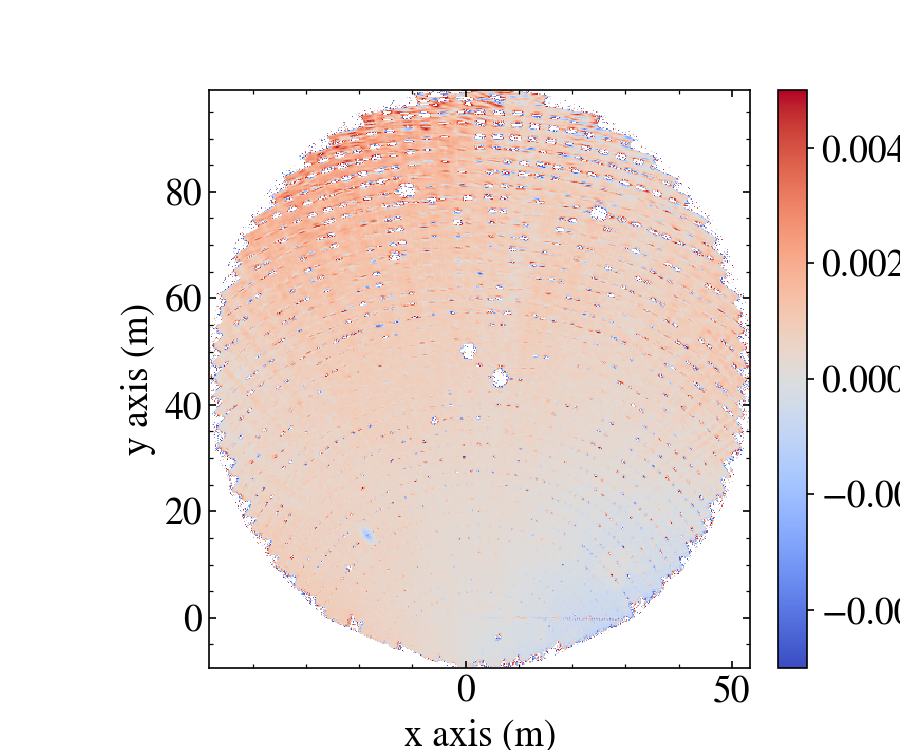

In [78]:
diff = np.ma.masked_invalid(zsg - zrg)
diff = np.ma.masked_outside(diff, -5e-3, 5e-3)
surfacePlot(xrg, yrg, diff.T)

/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:127: RuntimeWarning: invalid value encountered in greater
  mask = (abs(diff - diff_avg)/diff_rms > threshold) | (diff_rms == 0)
/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:127: RuntimeWarning: invalid value encountered in greater
  mask = (abs(diff - diff_avg)/diff_rms > threshold) | (diff_rms == 0)
/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:127: RuntimeWarning: invalid value encountered in greater
  mask = (abs(diff - diff_avg)/diff_rms > threshold) | (diff_rms == 0)
/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:127: RuntimeWarning: invalid value encountered in greater
  mask = (abs(diff - diff_avg)/diff_rms > threshold) | (diff_rms == 0)
/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:127: RuntimeWarning: invalid value encountered in greater
  mask = (abs(diff - diff_avg)/diff_rms > threshold) | (diff_rms == 0)
/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/util

<IPython.core.display.Javascript object>


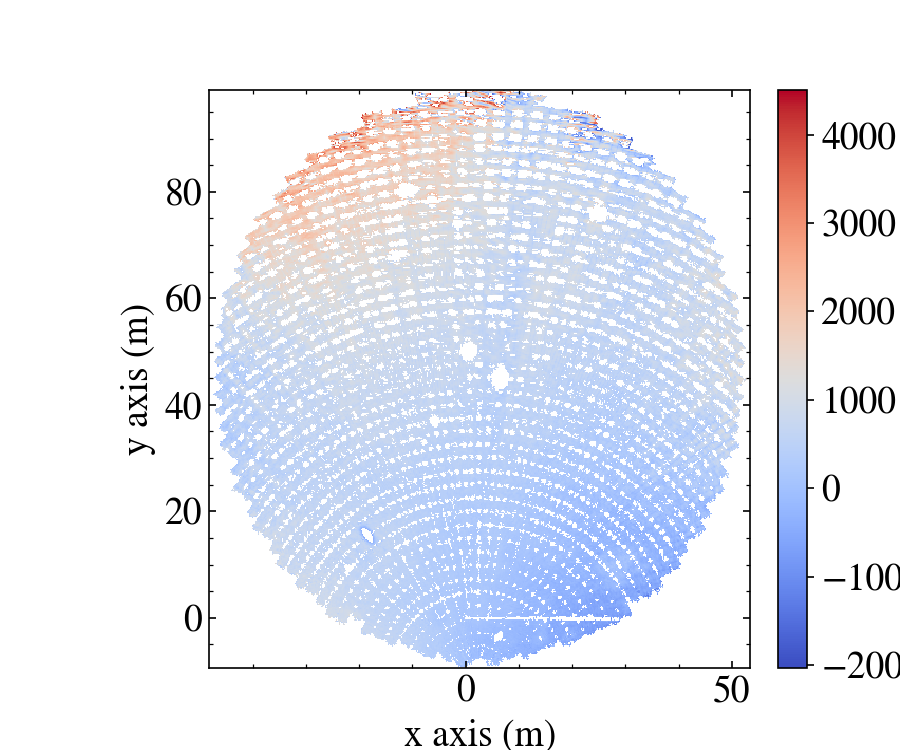

CPU times: user 19.8 s, sys: 9.6 s, total: 29.4 s
Wall time: 29.4 s


In [79]:
%%time

mDiff = maskData(diff)
for i in range(maskIters):
    mDiff = maskData(mDiff)
    
vmin = np.nanmin(mDiff*1e6)
vmax = np.nanmax(mDiff*1e6)
surfacePlot(xrg, yrg, mDiff.T*1e6, vMin=vmin, vMax=vmax, midPoint=(vmin+vmax)*0.5)

<IPython.core.display.Javascript object>


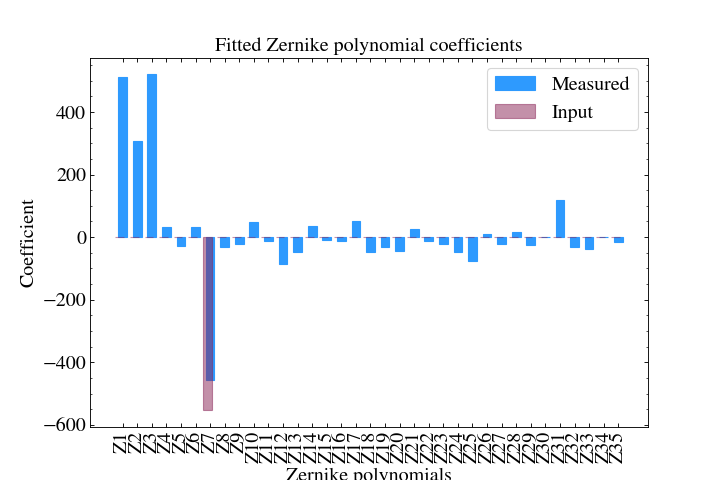

-455.42090822901014


In [80]:
fl_fs = getZernikeCoeffs(mDiff.filled(0)[::-1].T, 36, norm='active-surface')
barChartPlot(np.arange(1,36), fl_fs[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs[iz]*1e6)

Number of iterations: 2


<IPython.core.display.Javascript object>


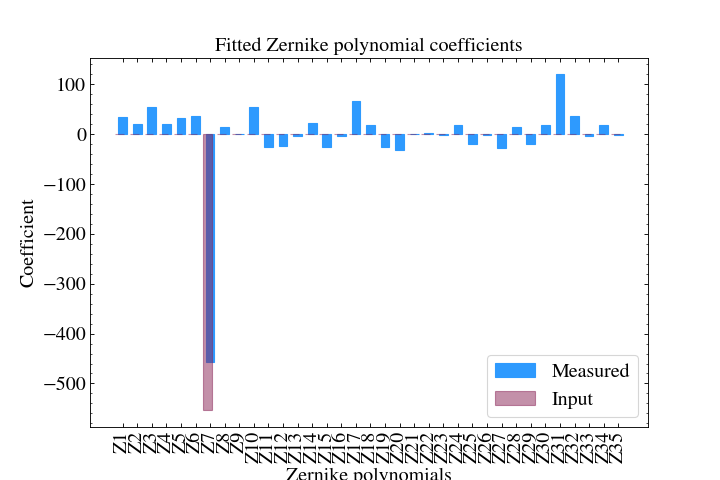

-456.43998817281937


<IPython.core.display.Javascript object>


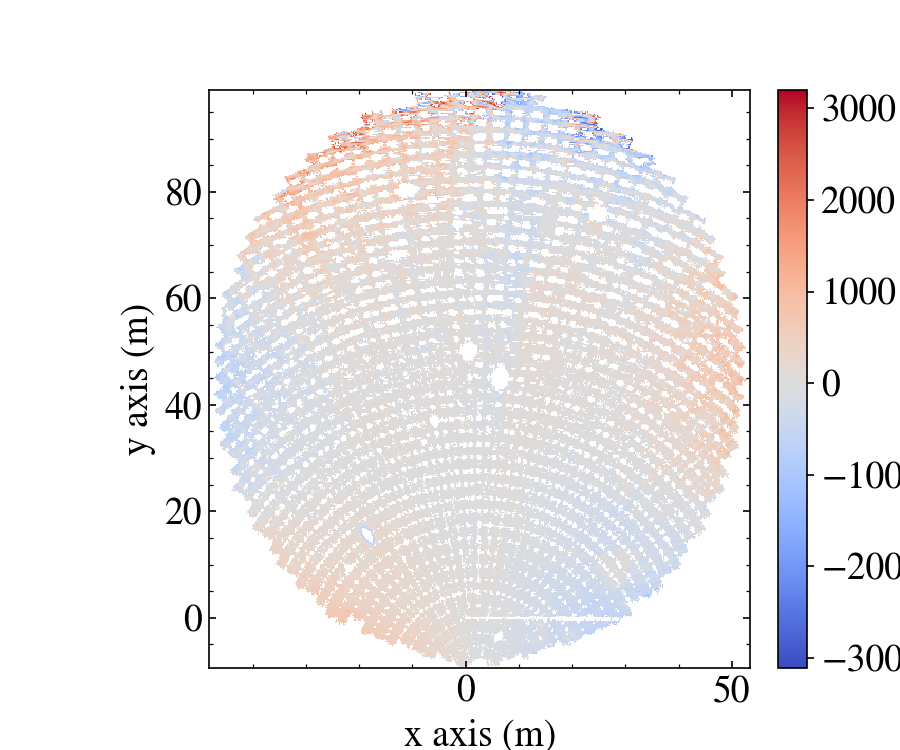

In [81]:
diff_ = np.ma.copy(mDiff)
fl_fs_sub = np.copy(fl_fs)
it = 0
while np.any(abs(fl_fs_sub[2:4]) > 100e-6):
    #fl_fs_sub[1] *= 0.
    fl_fs_sub[2] *= -1.
    zpoly_ = zernikePoly(xrg, yrg, midPoint(xrg), midPoint(yrg), fl_fs_sub[0:4])
    diff_ = diff_ - zpoly_
    fl_fs_sub = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
    it += 1
print("Number of iterations: {}".format(it))
barChartPlot(np.arange(1,36), fl_fs_sub[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs_sub[iz]*1e6)
surfacePlot(xrg, yrg, diff_.T*1e6, vMin=np.nanmin(diff_*1e6), vMax=np.nanmax(diff_*1e6))

/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:127: RuntimeWarning: invalid value encountered in greater
  mask = (abs(diff - diff_avg)/diff_rms > threshold) | (diff_rms == 0)
/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:127: RuntimeWarning: invalid value encountered in greater
  mask = (abs(diff - diff_avg)/diff_rms > threshold) | (diff_rms == 0)


<IPython.core.display.Javascript object>


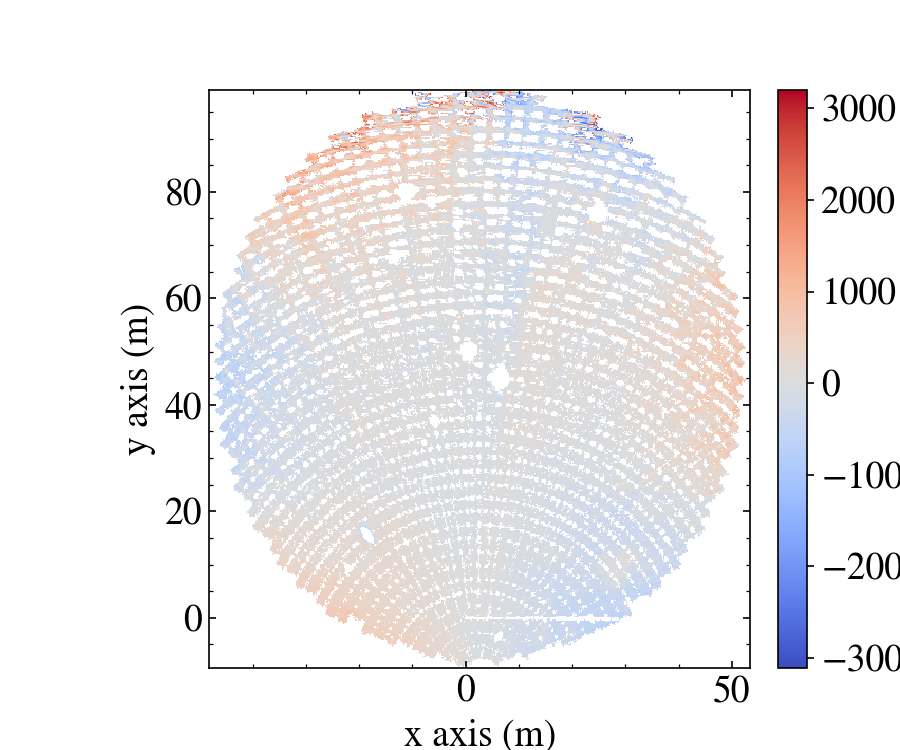

CPU times: user 5.13 s, sys: 2.41 s, total: 7.54 s
Wall time: 7.54 s


In [82]:
%%time
mDiff_ = maskData(diff_)
vmin = np.nanmin(mDiff_*1e6)
vmax = np.nanmax(mDiff_*1e6)
surfacePlot(xrg, yrg, mDiff_.T*1e6, vMin=vmin, vMax=vmax, midPoint=(vmin+vmax)*0.5)

<IPython.core.display.Javascript object>


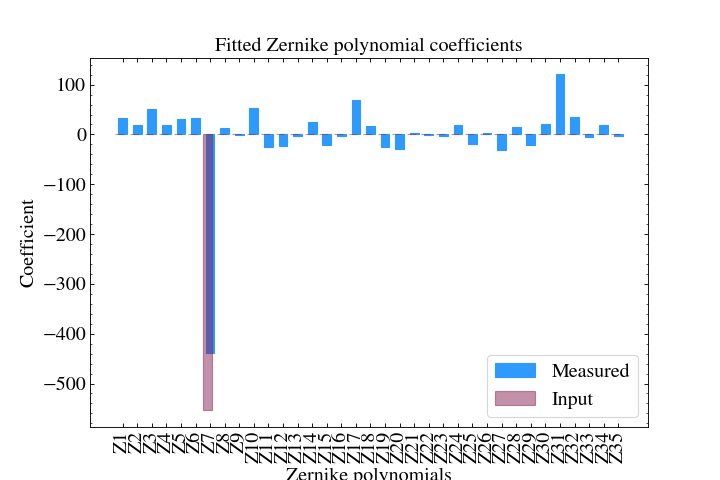

-438.7089210468083


In [83]:
fl_fs = getZernikeCoeffs(mDiff_.filled(0)[::-1].T, 36, norm='active-surface')
barChartPlot(np.arange(1,36), fl_fs[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs[iz]*1e6)

Number of iterations: 1


<IPython.core.display.Javascript object>


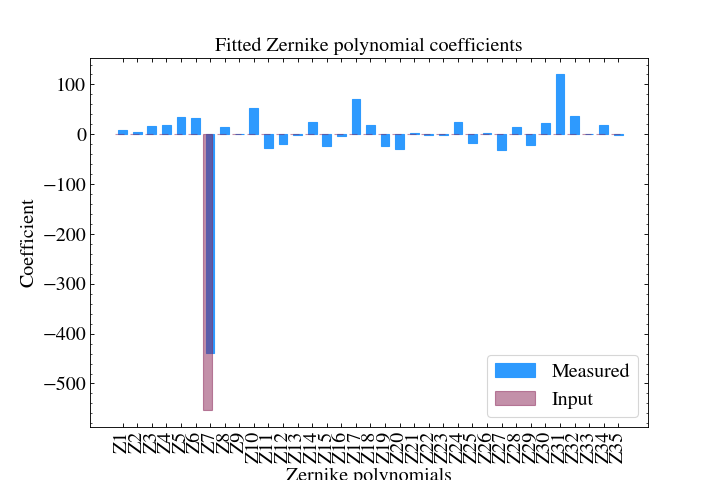

-439.0607810235766


<IPython.core.display.Javascript object>


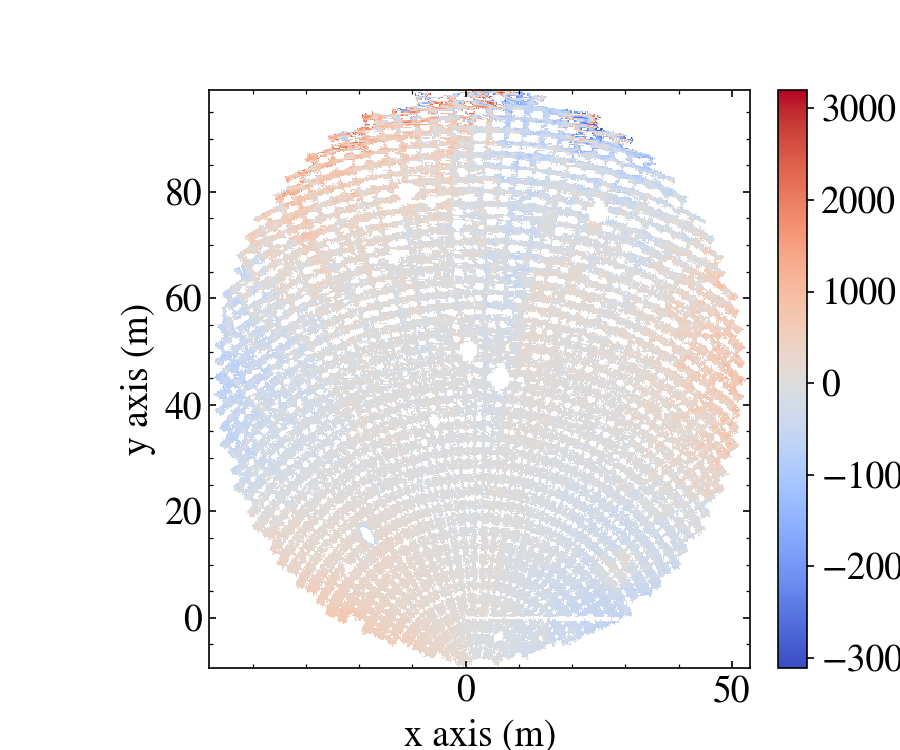

In [84]:
diff__ = np.ma.copy(mDiff_)
fl_fs_sub = np.copy(fl_fs)
it = 0
while np.any(abs(fl_fs_sub[2:4]) > 50e-6):
    #fl_fs_sub[1] *= 0.
    fl_fs_sub[2] *= -1.
    zpoly_ = zernikePoly(xrg, yrg, midPoint(xrg), midPoint(yrg), fl_fs_sub[0:4])
    diff__ = diff__ - zpoly_
    fl_fs_sub = getZernikeCoeffs(diff__.filled(0)[::-1].T, 36, norm='active-surface')
    it += 1
print("Number of iterations: {}".format(it))
barChartPlot(np.arange(1,36), fl_fs_sub[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs_sub[iz]*1e6)
surfacePlot(xrg, yrg, diff__.T*1e6, vMin=np.nanmin(diff_*1e6), vMax=np.nanmax(diff_*1e6))

In [85]:
mDiff_last = np.ma.masked_where(mDiff_.mask, diff)

<IPython.core.display.Javascript object>


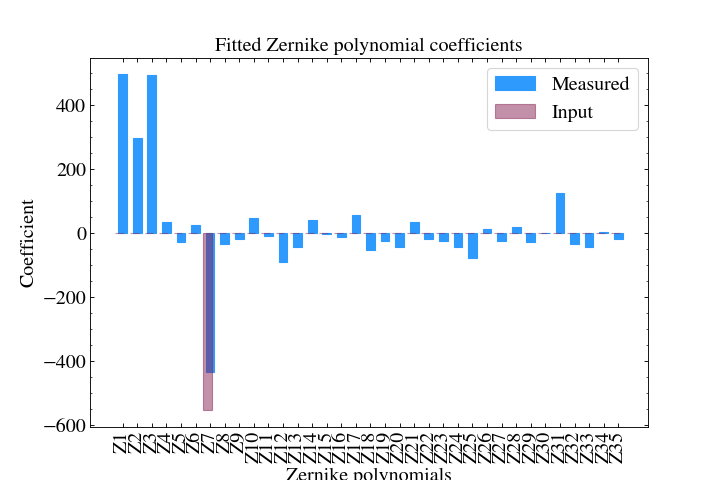

-434.2532937728037


<IPython.core.display.Javascript object>


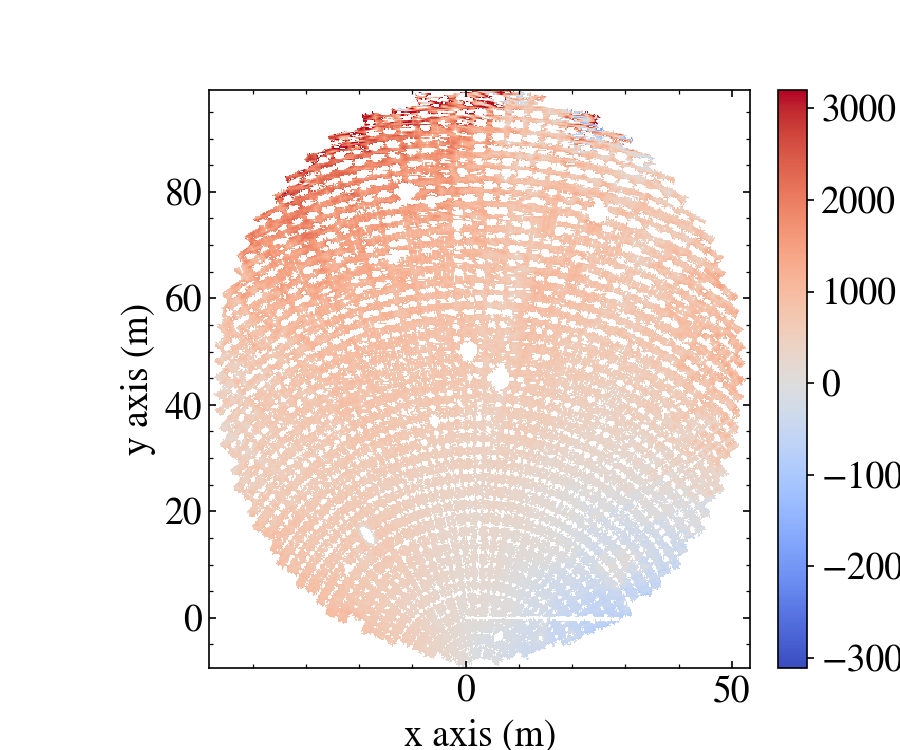

In [86]:
fl_fs = getZernikeCoeffs(mDiff_last.filled(0)[::-1].T, 36, norm='active-surface')
barChartPlot(np.arange(1,36), fl_fs[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs[iz]*1e6)
surfacePlot(xrg, yrg, mDiff_last.T*1e6, vMin=np.nanmin(diff_*1e6), vMax=np.nanmax(diff_*1e6))

Number of iterations: 3


<IPython.core.display.Javascript object>


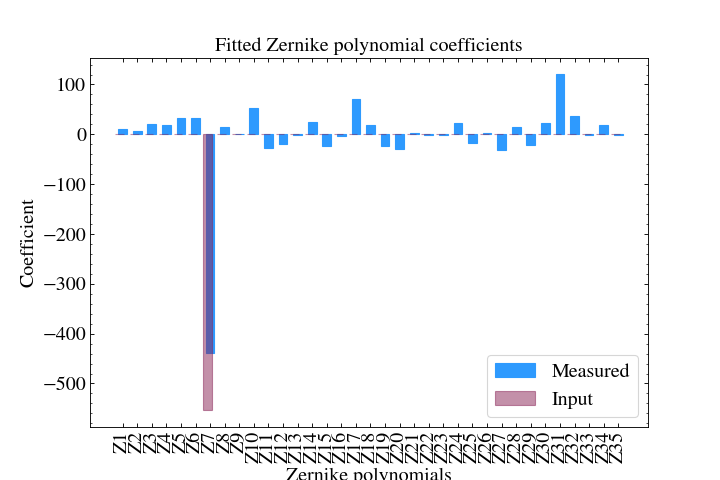

-439.02308147749346


<IPython.core.display.Javascript object>


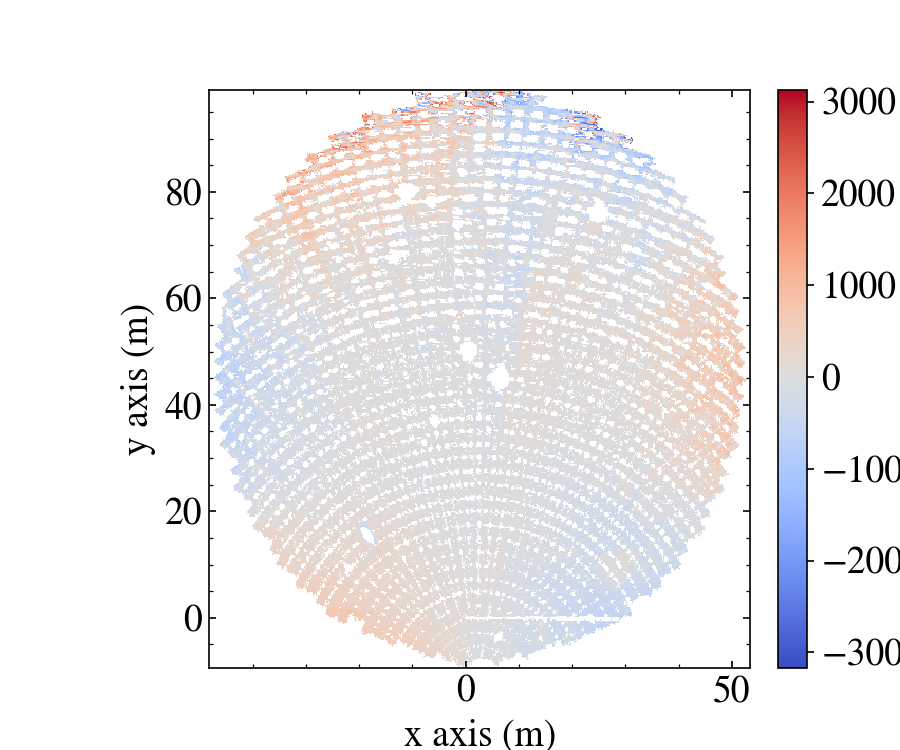

In [87]:
diff_ = np.ma.copy(mDiff_last)
fl_fs_sub = np.copy(fl_fs)
it = 0
while np.any(abs(fl_fs_sub[2:4]) > 50e-6):
    #fl_fs_sub[1] *= 0.
    fl_fs_sub[2] *= -1.
    zpoly_ = zernikePoly(xrg, yrg, midPoint(xrg), midPoint(yrg), fl_fs_sub[0:4])
    diff_ = diff_ - zpoly_
    fl_fs_sub = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
    it += 1
print("Number of iterations: {}".format(it))
barChartPlot(np.arange(1,36), fl_fs_sub[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs_sub[iz]*1e6)
surfacePlot(xrg, yrg, diff_.T*1e6, vMin=np.nanmin(diff_*1e6), vMax=np.nanmax(diff_*1e6))